In [1]:
import pandas as pd
df = pd.read_csv('Dataset/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv')
print(f"Shape: {df.shape}")
print(f"Columns:{df.columns.tolist()}")
print(f"Head:")
df.head()

Shape: (1918, 7)
Columns:['Date', 'Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']
Head:


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,16436,10705,225,19026,3925,59.0
1,15/09/2023,15499,10671,267,18421,4519,61.0
2,28/12/2021,1756,2352,0,3775,0,13.0
3,11/01/2023,10536,8347,223,14072,0,48.0
4,11/09/2021,820,612,0,1283,0,11.0


In [2]:
df = df.dropna(how='all')
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')

df = df.drop_duplicates()

for col in df.select_dtypes(include=['object']).columns:
    sample = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else None
    if sample:
        pd.to_datetime(sample)
        df[col] = pd.to_datetime(df[col], errors='coerce')

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

df = df.reset_index(drop=True)

/tmp/ipykernel_29061/1263014052.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pd.to_datetime(sample)
/tmp/ipykernel_29061/1263014052.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [3]:
date_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
df = df.sort_values(by=date_cols[0]).reset_index(drop=True)

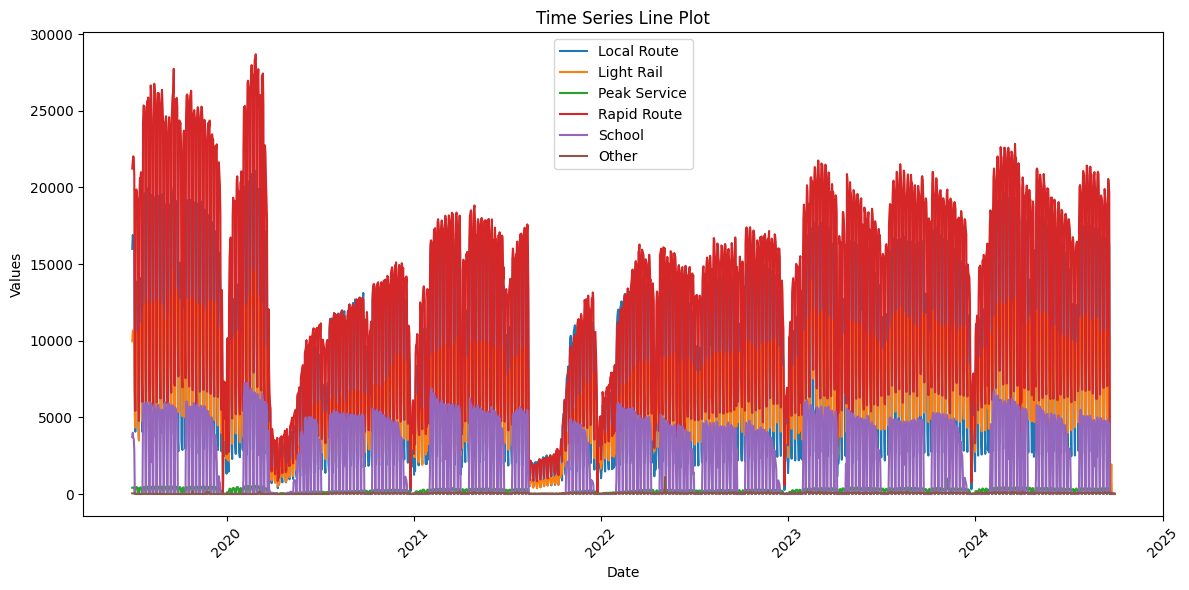

In [5]:
import matplotlib.pyplot as plt

date_col = df.select_dtypes(include=['datetime64']).columns[0]
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

plt.figure(figsize=(12, 6))
for col in numeric_cols:
    plt.plot(df[date_col], df[col], label=col)

plt.xlabel(date_col)
plt.ylabel('Values')
plt.title('Time Series Line Plot')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

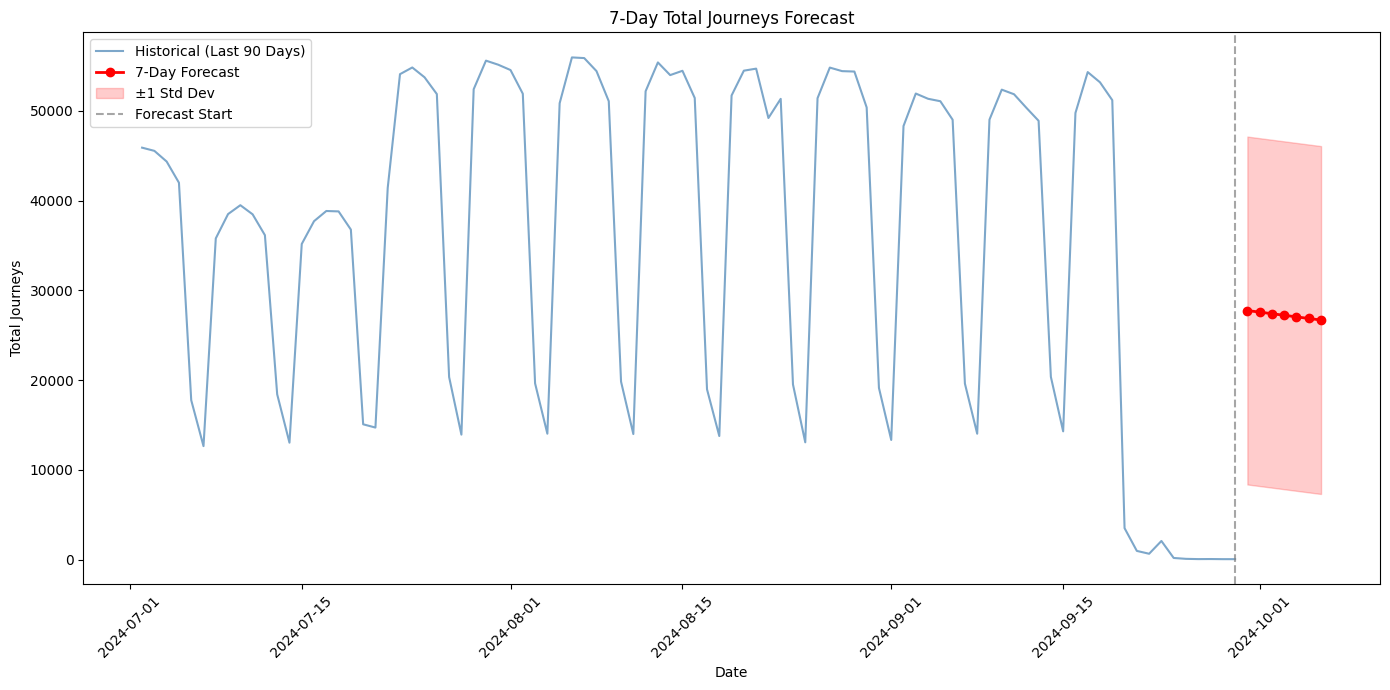

7-Day Forecast:
  2024-09-30: 27746 journeys
  2024-10-01: 27570 journeys
  2024-10-02: 27393 journeys
  2024-10-03: 27216 journeys
  2024-10-04: 27040 journeys
  2024-10-05: 26863 journeys
  2024-10-06: 26686 journeys


In [6]:
from sklearn.linear_model import LinearRegression
import numpy as np

date_col = df.select_dtypes(include=['datetime64']).columns[0]
service_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']

df_sorted = df.sort_values(by=date_col).copy()
df_sorted['Total Journeys'] = df_sorted[service_cols].sum(axis=1)

df_recent = df_sorted.tail(90).copy()
df_recent['Days'] = (df_recent[date_col] - df_recent[date_col].min()).dt.days

X = df_recent['Days'].values.reshape(-1, 1)
y = df_recent['Total Journeys'].values

model = LinearRegression()
model.fit(X, y)

last_date = df_sorted[date_col].max()
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')
forecast_days = np.array([(d - df_recent[date_col].min()).days for d in forecast_dates]).reshape(-1, 1)
forecast_values = model.predict(forecast_days)

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast_values
})

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df_recent[date_col], df_recent['Total Journeys'], color='steelblue', alpha=0.7, label='Historical (Last 90 Days)')

ax.plot(forecast_df['Date'], forecast_df['Forecast'], color='red', linewidth=2, marker='o', label='7-Day Forecast')

std = df_recent['Total Journeys'].std()
ax.fill_between(forecast_df['Date'], forecast_df['Forecast'] - std, forecast_df['Forecast'] + std, 
                color='red', alpha=0.2, label='±1 Std Dev')

ax.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, label='Forecast Start')

ax.set_xlabel('Date')
ax.set_ylabel('Total Journeys')
ax.set_title('7-Day Total Journeys Forecast')
ax.legend(loc='best')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("7-Day Forecast:")
for _, row in forecast_df.iterrows():
    print(f"  {row['Date'].strftime('%Y-%m-%d')}: {row['Forecast']:.0f} journeys")